<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_7` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [16]:
data = pd.read_csv('data/cookie_cats.csv')

g30 = data[data['version'] == 'gate_30']
g40 = data[data['version'] == 'gate_40']

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


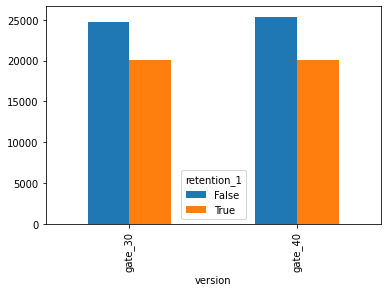

In [11]:
pd.crosstab(data['version'], data['retention_7']).plot(kind='bar');

In [17]:
# muestreo
g30['retention_7'].count(), g30['retention_7'].sum()

(44700, 20034)

In [21]:
# Plot beta distributions 



def plot_betas(betas, nombres): # Objeto con las distribuciones betas, nombres de cada grupo
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

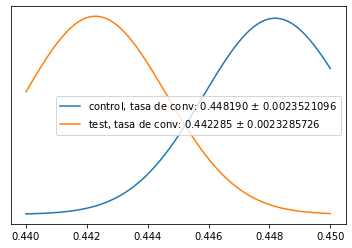

In [119]:
# testeo para retention_1
from scipy.stats import bernoulli, beta

tot_ctrl, ret_ctrl = g30['retention_1'].count(), g30['retention_1'].sum()
tot_test, ret_test = g40['retention_1'].count(), g40['retention_1'].sum()

RR_ctrl = ret_ctrl / tot_ctrl
RR_test = ret_test / tot_test

a_C, b_C = ret_ctrl + 1, tot_ctrl - ret_ctrl + 1
a_T, b_T = ret_test + 1, tot_test - ret_test + 1

beta_control = beta(a_C, b_C)
beta_test = beta(a_T, b_T)

x=np.linspace(0.44, 0.45, 1000)
plot_betas([beta_control, beta_test], ['control', 'test']);

In [121]:
1 - beta_control.cdf(0.4455)

0.8736562179199893

In [30]:
salto = (beta_test.mean() - beta_control.mean()) / beta_control.mean()

salto

-0.013175098158249857

In [103]:
from scipy.stats import beta

b = beta(a_C, b_C)
b.cdf(0.19)

0.4548265881073684

You should consider upgrading via the 'C:\Users\jgcha\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [113]:
x=np.linspace(0, 1, 1000)
#prob = beta_control.cdf(0.19, loc = g30['retention_1'].mean(), scale = g30['retention_1'].std())

beta_control.cdf(0.446)



0.17589434251586694

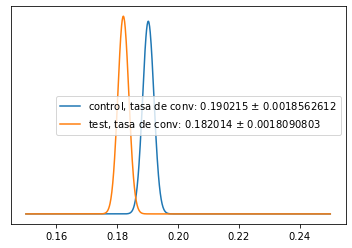

In [124]:
# testeo para retention_7

tot_ctrl, ret_ctrl = g30['retention_7'].count(), g30['retention_7'].sum()
tot_test, ret_test = g40['retention_7'].count(), g40['retention_7'].sum()

RR_ctrl = ret_ctrl / tot_ctrl
RR_test = ret_test / tot_test

a_C, b_C = ret_ctrl + 1, tot_ctrl - ret_ctrl + 1
a_T, b_T = ret_test + 1, tot_test - ret_test + 1

beta_control = beta(a_C, b_C)
beta_test = beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

x=np.linspace(0.15, 0.25, 1000)
plot_betas([beta_control, beta_test], ['control', 'test']);

In [125]:
1 - beta_control.cdf(0.185)

0.9976506533629376

In [ ]:
"""Atendiendo a los datos, la versión con la puerta al nivel 30 genera una mayor tasa de retención tanto para 1 día (88 % de probabilidad) como para 7 (99 % de probabilidad)."""
